# Time Series with LSTMs
Yun Xing. 2023-5-14


In [1]:
import sys
import os
import json
import pandas as pd
import numpy as np
import optparse

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence  # fixed later

from collections import OrderedDict
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('DAYTON_hourly.csv')
df.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [3]:
df.isnull().sum()

Datetime     0
DAYTON_MW    0
dtype: int64

In [4]:
df.Datetime = pd.to_datetime(df.Datetime)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datetime   121275 non-null  datetime64[ns]
 1   DAYTON_MW  121275 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [6]:
df.sort_values(by="Datetime", inplace=True)

df.head()

,Datetime,DAYTON_MW
2183,2004-10-01 01:00:00,1621.0
2184,2004-10-01 02:00:00,1536.0
2185,2004-10-01 03:00:00,1500.0
2186,2004-10-01 04:00:00,1434.0
2187,2004-10-01 05:00:00,1489.0


In [7]:
df.shape

(121275, 2)

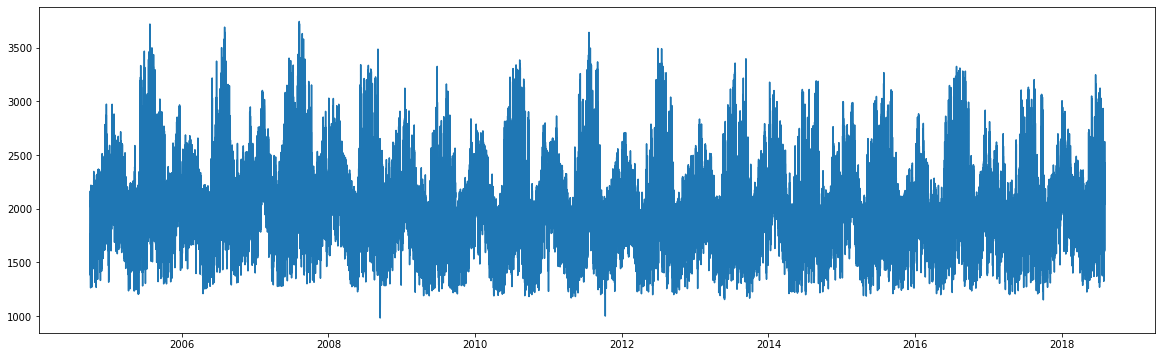

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(df['Datetime'], df['DAYTON_MW'])
plt.show()

In [9]:
# Train test split (from helper.py) as we can’t use sklearn’s for time series data)

from typing import Tuple

def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split
    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set
    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy arrays
    """
    y = data[Y_var].tolist()
    
    X, Y = [], []
    
    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])
    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Creating training and test sets
    X_train = X
    X_test = []

    Y_train = Y
    Y_test = []

    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]

        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]

    return X_train, X_test, Y_train, Y_test

### Fit a single layer LSTM with lag = 3 hours

In [10]:
lag = 3
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = create_data_for_NN(
    df, df.columns[-1], lag, test_ratio)

In [11]:
X_train.shape

(103081, 3, 1)

In [12]:
b_model = Sequential()

b_model.add(LSTM(units=64, input_shape = (3,1),recurrent_dropout=0.5, activation="relu"))
b_model.add(Dense(units=1, activation="relu"))

b_model.compile(loss="mean_squared_error", optimizer="adam", 
                metrics=[tf.keras.metrics.RootMeanSquaredError()] )


In [13]:
b_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
b_model.fit(X_train, Y_train, validation_split=0.25, epochs=10, batch_size=128)


Epoch 1/10
604/604 [==============================] - 4s 4ms/step - loss: 189331.4844 - root_mean_squared_error: 435.1224 - val_loss: 27728.0703 - val_root_mean_squared_error: 166.5175
Epoch 2/10
604/604 [==============================] - 2s 4ms/step - loss: 18835.3789 - root_mean_squared_error: 137.2421 - val_loss: 15978.7803 - val_root_mean_squared_error: 126.4072
Epoch 3/10
604/604 [==============================] - 2s 4ms/step - loss: 13767.4375 - root_mean_squared_error: 117.3347 - val_loss: 16052.1992 - val_root_mean_squared_error: 126.6973
Epoch 4/10
604/604 [==============================] - 3s 4ms/step - loss: 11344.3701 - root_mean_squared_error: 106.5100 - val_loss: 16525.0234 - val_root_mean_squared_error: 128.5497
Epoch 5/10
604/604 [==============================] - 2s 4ms/step - loss: 8216.5479 - root_mean_squared_error: 90.6452 - val_loss: 22297.1387 - val_root_mean_squared_error: 149.3223
Epoch 6/10
604/604 [==============================] - 2s 4ms/step - loss: 6636.21

In [15]:
y_pred = b_model.predict(X_test)

569/569 [==============================] - 1s 1ms/step


In [16]:
loss, rmse = b_model.evaluate(X_test, Y_test, batch_size=128)

print("Test RMSE:", rmse)


143/143 [==============================] - 0s 1ms/step - loss: 13908.5176 - root_mean_squared_error: 117.9344
Test RMSE: 117.93437957763672


### Fit a single layer LSTM with lag = 24 hours

In [17]:
lag2 = 24
test_ratio = 0.15

X_train2, X_test2, Y_train2, Y_test2 = create_data_for_NN(
    df, df.columns[-1], lag2, test_ratio)

In [18]:
X_train2.shape


(103063, 24, 1)

In [19]:

b_model2 = Sequential()

b_model2.add(LSTM(units=64, input_shape = (24,1),recurrent_dropout=0.5, activation="relu"))
b_model2.add(Dense(units=1, activation="relu"))

b_model2.compile(loss="mean_squared_error", optimizer="adam", 
                metrics=[tf.keras.metrics.RootMeanSquaredError()] )
b_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [20]:
b_model2.fit(X_train2, Y_train2, validation_split=0.25, epochs = 10, batch_size = 128)

Epoch 1/10
604/604 [==============================] - 11s 17ms/step - loss: 975270.5625 - root_mean_squared_error: 987.5579 - val_loss: 2315849.5000 - val_root_mean_squared_error: 1521.7915
Epoch 2/10
604/604 [==============================] - 10s 17ms/step - loss: 669926.6875 - root_mean_squared_error: 818.4905 - val_loss: 1216281.8750 - val_root_mean_squared_error: 1102.8517
Epoch 3/10
604/604 [==============================] - 10s 17ms/step - loss: 771965.1875 - root_mean_squared_error: 878.6155 - val_loss: 822034.8125 - val_root_mean_squared_error: 906.6614
Epoch 4/10
604/604 [==============================] - 10s 17ms/step - loss: 1050893.7500 - root_mean_squared_error: 1025.1311 - val_loss: 458292.2188 - val_root_mean_squared_error: 676.9728
Epoch 5/10
604/604 [==============================] - 10s 17ms/step - loss: 1142444.1250 - root_mean_squared_error: 1068.8518 - val_loss: 916665.6250 - val_root_mean_squared_error: 957.4266
Epoch 6/10
604/604 [==============================] 

In [21]:
y_pred2 = b_model2.predict(X_test2)


569/569 [==============================] - 2s 2ms/step


In [22]:
loss2, rmse2 = b_model2.evaluate(X_test2, Y_test2)

print("Test RMSE:", rmse2)


569/569 [==============================] - 2s 3ms/step - loss: 795075.1250 - root_mean_squared_error: 891.6699
Test RMSE: 891.6698608398438


### Fit a bidirectional LSTM with lag = 24 hours

In [23]:
lag3 = 24
test_ratio = 0.15

X_train3, X_test3, Y_train3, Y_test3 = create_data_for_NN(
    df, df.columns[-1], lag3, test_ratio)

In [24]:
from tensorflow.keras.layers import Bidirectional

b_model3 = Sequential()

b_model3.add(Bidirectional(LSTM(units=64, input_shape=(24,1),
                                recurrent_dropout=0.5, activation = 'relu'))) #input size same as x SHAPE -1
b_model3.add(Dense(units=1, activation='relu'))

b_model3.compile(loss="mean_squared_error", optimizer="adam", 
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [25]:
b_model3.fit(X_train3, Y_train3, validation_split=0.25, epochs = 10, batch_size = 128)

Epoch 1/10
604/604 [==============================] - 16s 21ms/step - loss: 822337.5000 - root_mean_squared_error: 906.8282 - val_loss: 672854.2500 - val_root_mean_squared_error: 820.2769
Epoch 2/10
604/604 [==============================] - 12s 21ms/step - loss: 362218.8750 - root_mean_squared_error: 601.8463 - val_loss: 697807.8750 - val_root_mean_squared_error: 835.3489
Epoch 3/10
604/604 [==============================] - 13s 21ms/step - loss: 433915.7188 - root_mean_squared_error: 658.7228 - val_loss: 302830.1250 - val_root_mean_squared_error: 550.3000
Epoch 4/10
604/604 [==============================] - 12s 21ms/step - loss: 514123.5312 - root_mean_squared_error: 717.0241 - val_loss: 265479.0000 - val_root_mean_squared_error: 515.2465
Epoch 5/10
604/604 [==============================] - 13s 21ms/step - loss: 535574.3125 - root_mean_squared_error: 731.8294 - val_loss: 529703.9375 - val_root_mean_squared_error: 727.8076
Epoch 6/10
604/604 [==============================] - 13s 21

In [26]:
b_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              33792     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


In [27]:
y_pred3 = b_model3.predict(X_test3)


569/569 [==============================] - 3s 4ms/step


In [28]:
loss3, rmse3 = b_model3.evaluate(X_test3, Y_test3)

print("Test RMSE:", rmse3)


569/569 [==============================] - 3s 5ms/step - loss: 184431.3281 - root_mean_squared_error: 429.4547
Test RMSE: 429.4546813964844


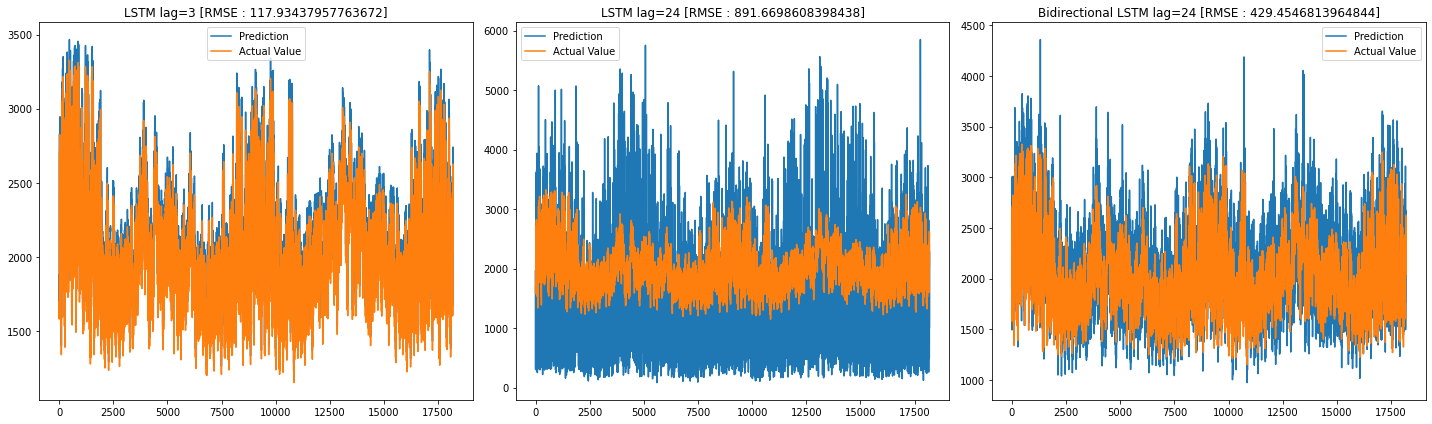

In [29]:
# Plot results on test set

pred = [y_pred, y_pred2, y_pred3]
title = ["LSTM lag=3", "LSTM lag=24", 'Bidirectional LSTM lag=24']
RMSE = [rmse, rmse2, rmse3]

plt.figure(figsize=(20,6))

for i in range(3):
     
    _ = plt.subplot(1,3,i+1)
    _ = plt.plot(pred[i], label = 'Prediction')
    _ = plt.plot(Y_test, label = 'Actual Value')
    _ = plt.title(f'{title[i]} [RMSE : {RMSE[i]}]')
    _ = plt.legend()
_ = plt.tight_layout()

In [30]:
# plot RMSE
print('RMSE for model1 (LSTM with lag=3): ', rmse)
print('RMSE for model2 (LSTM with lag=24): ', rmse2)
print('RMSE for model3 (Bidirectional LSTM with lag=24): ', rmse3)

RMSE for model1 (LSTM with lag=3):  117.93437957763672
RMSE for model2 (LSTM with lag=24):  891.6698608398438
RMSE for model3 (Bidirectional LSTM with lag=24):  429.4546813964844


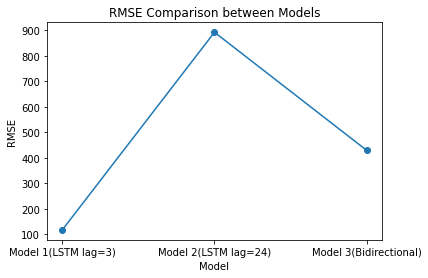

In [31]:
model_labels = ['Model 1(LSTM lag=3)', 'Model 2(LSTM lag=24)', 'Model 3(Bidirectional)']

# Create line plot
plt.plot(model_labels, [rmse, rmse2, rmse3], marker='o')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison between Models')
plt.show()

From the prediction results and the RMSE value, the Single Layer LSTM (Lag= 3) model has the lowest RMSE and best performance in prediction.